In [ ]:
# First Define all the tools

In [120]:
%matplotlib inline
import os
import mdtraj as md
from scipy.signal import correlate , fftconvolve
from tqdm import tqdm
import numpy as np
import json
from pylab import *


def load_parameters(filename):

    with open(filename, "r") as f:
        traj = json.load(f)
    return traj

def check_rep(rep,n=10):
    #To check that all particules stayed inside the nucleus
    data_folder = rep + "/traj%i"%n
    
    for i in tqdm(range(n)):
        #print
        if os.path.exists(data_folder):
            t = md.load(os.path.join(data_folder, 'poly.dcd'),
                top=os.path.join(data_folder, "atoms.hoomdxml"))
            if np.max(t.xyz) > 5:
                print(np.max(t.xyz))
    return t
            
    
def get_coord(resid,on_chain,t):

    sele = "resid %i"%resid
    #print(t,sele,t.topology.select("resid 0"))
    start = t.topology.select(sele)[0]
    sele += " and index %i"%(start+on_chain) 
    #print(sele)
    indexes = t.topology.select(sele)
    Coords = np.mean(t.xyz[::,indexes],axis=1).T
    return Coords

#Fast MSD (Correct only on the first half)
def MSDF(Coords):
    x,y,z = Coords
    S1 = fftconvolve(x,x[::-1]) + fftconvolve(y,y[::-1]) +  fftconvolve(z,z[::-1])
    #print(len(S1))
    n = (len(S1)+1) // 2 
    #print((len(S1)+1)/2)
    S1  = S1[:n][::-1]  /range(n,0,-1)
    
    #return S1
    return 2*(sum(x**2 +y**2 +z**2)/len(x) -S1)

#Then to fit the different curves

def MSD(Coords,skip=1,stop=1000,nonOverlap=True):
    #print "MSD doing the calc"
    end = len(Coords[0])
    deb=0
    stop=stop
    indep=2000
    skip = skip
    #nonOverlap=True

    msd = np.zeros(end-deb-stop)
    for k in range(1,end-deb-stop,skip):
        n = 0
        if nonOverlap:
            indep = 0 + k
        else:
            indep = 1
        for i in range(0,end-k-deb,indep):
            start = Coords[::,i]
            pos = Coords[::,i+k]
#            import pdb
#            pdb.set_trace()
            msd[k] += np.sum((start-pos)**2)
            n += 1

        msd[k]  =  msd[k]  /n
    return msd[1::skip]



def MSDF(Coords):
    x,y,z = Coords
    S1 = fftconvolve(x,x[::-1]) + fftconvolve(y,y[::-1]) +  fftconvolve(z,z[::-1])
    #print(len(S1))
    n = (len(S1)+1) // 2 
    #print((len(S1)+1)/2)
    S1  = S1[:n][::-1]  /range(n,0,-1)
    
    #return S1
    return 2*(sum(x**2 +y**2 +z**2)/len(x) -S1)

def compute_mean_msd(t,p_chain = 40,micron=1.6,n_ch=16,stop=None):
    MSDsd = []
    mini = 10
    maxi = -10
    end=900

    for i in range(1,2):
        Coordsp = get_coord(i,on_chain=0,t=t) / micron * 10
        Coordsp=Coordsp[::,:stop]
        print(Coordsp.shape,stop)
        mini = min(mini,np.min(Coordsp))
        maxi = max(maxi,np.max(Coordsp))
        #print(mini,maxi)
        #print(np.max(Coords))
        if np.max(Coordsp) < 10:
            MSDsd.append(MSDF(Coordsp))
        else:
            print(np.max(Coordsp))

    #print(Coords)
    MSDsm = []
   


    for p in range(40,140):
        for i in range(0,1):
            Coords = get_coord(i,on_chain=p,t=t) / micron * 10
            mini = min(mini,np.min(Coords))
            maxi = max(maxi,np.max(Coords))
            MSDsm.append(MSDF(Coords)) 
            #MSDs.append(MSD(Coords,skip=1,nonOverlap=True))
            #plot(MSDs[-1][:end])
        #plot(np.mean(MSDsm,axis=0)[:end])
    print(mini,maxi)
    return np.mean(MSDsd,axis=0),np.mean(MSDsm,axis=0),Coordsp,Coords

from lmfit import Model

def confined(x, D, Rc):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return Rc**2 * (1-np.exp(-6 *D * x / Rc **2 ))

def diff(x, D, Rc):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return 6 *D * x 

def subdiffusif(x, D, alpha):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return 6 * D * x**alpha

Confined = Model(confined)
Subdiffusif = Model(subdiffusif)
Diff = Model(diff)


def fit(data,model="Sub",end=None,toplot=False,dt=1,**kwargs):

    #Fift
    if np.sum(np.isnan(data)) != 0 :
        print("Nan in")
    if model not in ["Sub","Conf","Diff"]:
        print("Wrong model")
        return
    
    if end is not None:
        data=data[:end]
    
    x = np.arange(len(data)) * dt
    
    if model is "Sub":
        result = Subdiffusif.fit(data, x=x, D=0.08, alpha=0.5)
    if model is "Conf":
        result = Confined.fit(data, x=x, D=0.01, Rc=1.)
    if model is "Diff":
        result = Diff.fit(data, x=x, D=0.08, Rc=1)
    if toplot:
        plot(x, result.best_fit, '-',**kwargs)
        plot(x,data,"ob",markersize=1)
    
    return result


# One particle, one interacting site, irreversible interaction

## Displacement as a function of time

In [173]:
rep = "..//../data/raw/test-bi//"
t = check_rep(rep,n=1)
param = load_parameters(rep+"/traj1/params.json")

Diffp,Mono,Coordsp,Coords = compute_mean_msd(t, p_chain=40, micron = 4*param["micron"],n_ch=1,stop=1500)
_,_,CoordspF,_= compute_mean_msd(t, p_chain=40, micron = 4*param["micron"],n_ch=1,stop=None)

100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


(3, 1500) 1500
-0.235842 0.233426
(3, 3190) None
-0.235842 0.233426


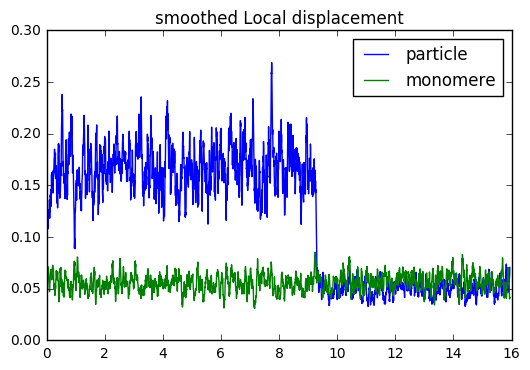

In [137]:
title("smoothed Local displacement")
dp = np.linalg.norm(CoordspF.T[1:]-CoordspF.T[:-1],axis=1)
plot(np.arange(len(dp))*0.005,pd.Series(dp).rolling(10,center=True,min_periods=1).mean(),label="particle")

dp = np.linalg.norm(Coords.T[1:]-Coords.T[:-1],axis=1)
plot(np.arange(len(dp))*0.005,pd.Series(dp).rolling(10,center=True,min_periods=1).mean(),label="monomere")
legend(loc="best")
#print(len(dp)/16)

## ANalysis of MSD

16
Diffusing element, diffusion coefficient 1.6 microm^2/s , Rc 0.25 microm
Fit of Monomers,  diffusion coefficient 0.1 microm^2/s


(0, 0.5)

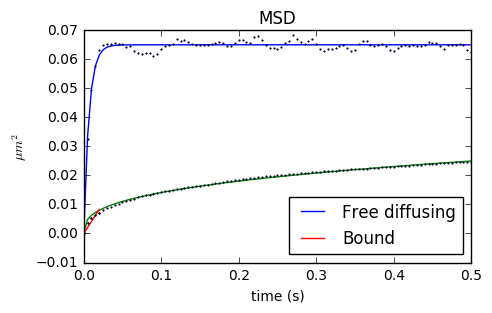

In [180]:
figure(figsize=(5,3))
title("MSD")
dt = 0.005
print(param["micron"])
res = fit(Diffp[:200],model="Conf",toplot=True,dt=dt,label="Free diffusing")
print("Diffusing element, diffusion coefficient %.1f microm^2/s , Rc %.2f microm" %(res.params["D"].value,res.params["Rc"].value))
res = fit(Mono[:200],model="Sub",toplot=True,dt=dt)
#print("Monomers",res.params["D"].value,res.params["alpha"].value)
res = fit(Mono[:200],model="Diff",toplot=True,dt=dt,end=5,label="Bound")
print("Fit of Monomers,  diffusion coefficient %.1f microm^2/s" %res.params["D"].value)
legend(loc="best")
xlabel("time (s)")
ylabel("$\mu m^2$")
xlim(0,0.5)

## histogram of displacement

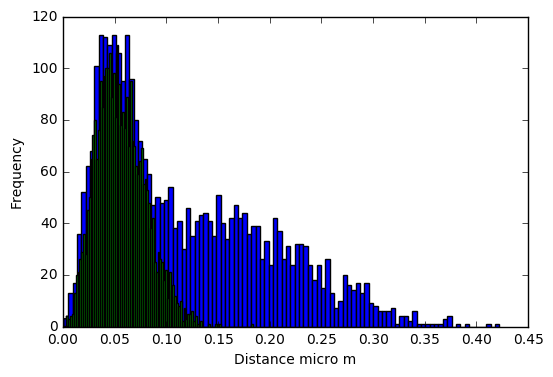

In [182]:
import pandas as pd
dp = np.linalg.norm(CoordspF.T[1:]-CoordspF.T[:-1],axis=1)
d = np.linalg.norm(Coords.T[1:]-Coords.T[:-1],axis=1)
#plot(pd.Series(d).rolling(20,center=True,min_periods=1).mean())
#plot(d)
hist(dp,bins=100,label="particle");
hist(d,bins=100,label="monomer");
xlabel("Distance micro m")
ylabel("Frequency")


## Scaling: 1 monomer = 1kb = 15 nm
## 1000 steps = 0.005 ms

# With transient interactions one particle and 10 sites on 3 Mb
16000 / 6000 = 3 site/Mb

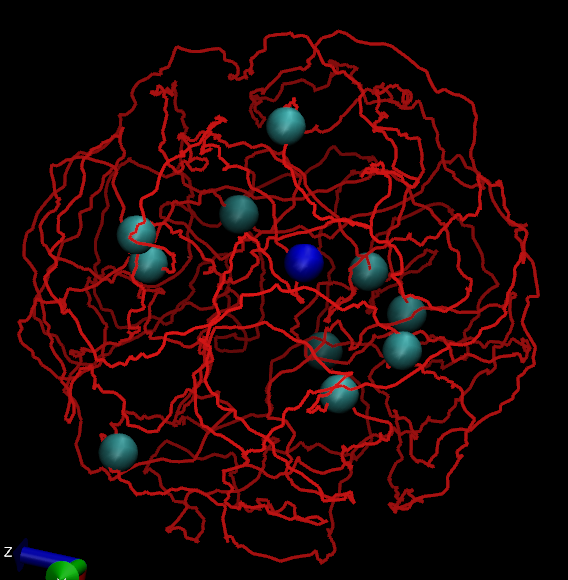

In [187]:
from IPython.display import Image
Image(filename='curve.png') 

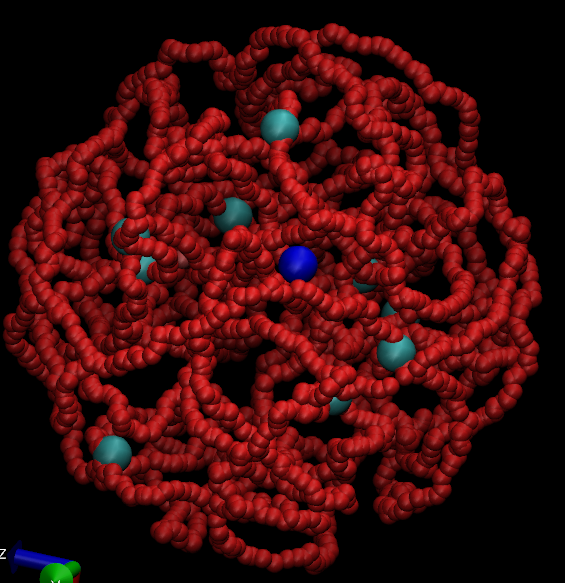

In [186]:
Image(filename='bead.png') 

In [140]:
rep = "..//../data/raw/test-inte-trans//"
t = check_rep(rep,n=1)
param = load_parameters(rep+"/traj1/params.json")

Diffp_t,Mono_t,Coordsp_t,Coords_t = compute_mean_msd(t, p_chain=40, micron = 4*param["micron"],n_ch=1,stop=None)
_,_,CoordspF_t,_= compute_mean_msd(t, p_chain=40, micron = 4*param["micron"],n_ch=1,stop=None)

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


(3, 9000) None
-0.235842 0.237022
(3, 9000) None
-0.235842 0.237022


(0, 0.3)

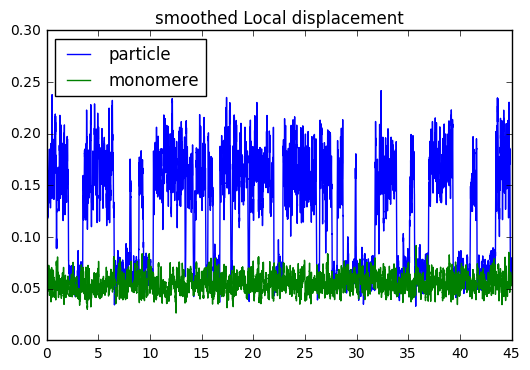

In [150]:
title("smoothed Local displacement")
dp_t = np.linalg.norm(CoordspF_t.T[1:]-CoordspF_t.T[:-1],axis=1)
plot(np.arange(len(dp_t))*0.005,pd.Series(dp_t).rolling(10,center=True,min_periods=1).mean(),label="particle")

d = np.linalg.norm(Coords_t.T[1:]-Coords_t.T[:-1],axis=1)
plot(np.arange(len(d))*0.005,pd.Series(d).rolling(10,center=True,min_periods=1).mean(),label="monomere")
legend(loc="best")
ylim(0,0.3)
#print(len(dp)/16)

## Histogram of displacement (Smoothed)

proportion of fast motion 0.625402822536


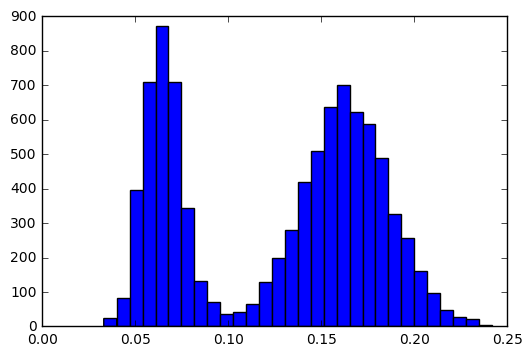

In [163]:
smth = pd.Series(dp_t).rolling(10,center=True,min_periods=1).mean()
hist(pd.Series(dp_t).rolling(10,center=True,min_periods=1).mean(),bins=30)
print("proportion of fast motion",sum(smth>0.1)/len(smth))

## Length of track

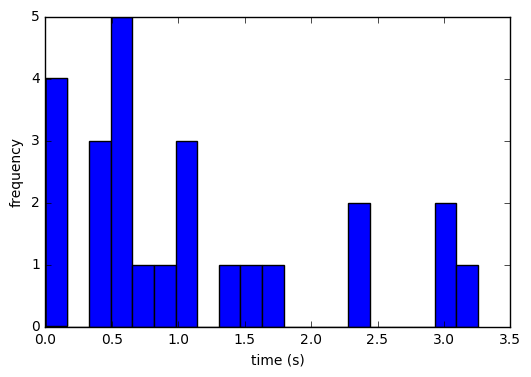

In [172]:
track = "".join(list(map(str,map(int,smth>0.1))))
lentrack = [len(t)*dt for t in track.split("0") if t != ""]
hist(lentrack,bins=20)
xlabel("time (s)")
ylabel("frequency")